Importing necessary packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Loading ResNet model and defining a function that will use the model to extract features from our images

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
def extract_features(img_path, model): 
  input_shape = (224, 224, 3)
  img = image.load_img(img_path, target_size=(
  input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0) 
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img)
  flattened_features = features.flatten()
  normalized_features = flattened_features / norm(flattened_features) 
  return normalized_features

Defining a function that will gather all of the image files from a directory

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG'] 
def get_file_list(root_dir):
  file_list = []
  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      file_list.append(root + "/" + filename)
  return file_list

Gathering all of the image files from the 101_ObjectCategories folder

In [ ]:
root_dir = '/content/drive/My Drive/Images/101_ObjectCategories'
filenames = get_file_list(root_dir)

/content/drive/My Drive/Images/101_ObjectCategories/ewer/image_0016.jpg


Using the function from earlier to extract features from all of the images in the folder

In [ ]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
  feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Saving the file names extracted features to a pickle file

In [ ]:
pickle.dump(feature_list, open('/content/drive/My Drive/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('/content/drive/My Drive/filenames-caltech101.pickle','wb'))

In [ ]:
feature_list = pickle.load(open('/content/drive/My Drive/features-caltech101-resnet.pickle', 'rb'))
filenames = pickle.load(open('/content/drive/My Drive/filenames-caltech101.pickle', 'rb'))

Fitting a brute force KNN model to the feature vectors

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[8000]])

Plotting the 8000th image in our file names

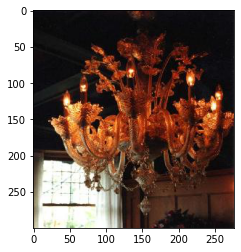

In [ ]:
plt.imshow(mpimg.imread(filenames[8000]))

Plotting the image with the closest feature vector identified by our KNN model


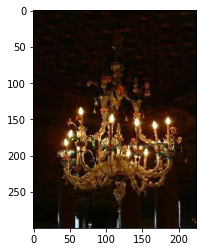

In [ ]:
plt.imshow(mpimg.imread(filenames[indices.tolist()[0][1]]))

Taking a random image from our files list and finding the closest image using our KNN model

In [ ]:
random_image_index = random.randint(0, len(filenames))
distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][1]]]

Plotting the random image

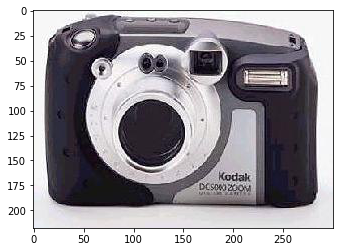

In [ ]:
plt.imshow(mpimg.imread(similar_image_paths[0]))

Plotting the closest image as identified by our model

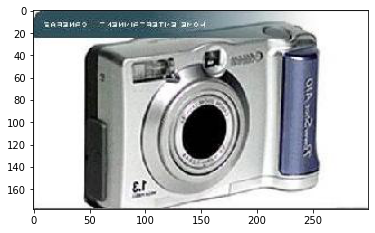

In [ ]:
  plt.imshow(mpimg.imread(filenames[indices[0][1]]))

Using PCA and T-SNE to reduce the dimension of our feature vectors so that we can plot them in 2-dimensions and visualize the images which have embeddings with a small euclidean distance between them 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_feature_dimensions =100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compresssed = pca.transform(feature_list)

selected_features = feature_list_compresssed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

tsne_results = TSNE(n_components=2, verbose=1, metric='euclidean').fit_transform(selected_features)

colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,1], cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()